In [3]:
import pickle
with open('imgs/ld_eval_imgs/fut_pred_dict/fut_dict1.pkl', 'rb') as f:
    fut_preds_dict =  pickle.load(f)

# print(fut_preds_dict)
for ds_id,ds_fut in fut_preds_dict.items():
    for tgt_id,tgt_fut in ds_fut.items():
        print(f"dataset id: {ds_id}  target_id: {tgt_id}, sample number: {len(tgt_fut)}")

dataset id: 7  target_id: 36, sample number: 282
dataset id: 5  target_id: 37, sample number: 2919


In [4]:
from ld_dataset import LD_Dataset, get_smp_list_ds_df_dict, get_tgt_smp
from collections import defaultdict

sample_dir = "ld_data/processed_samples_list"
csv_dir = "ld_data/processed_csvs"
samples_list, ds_df_dict = get_smp_list_ds_df_dict(sample_dir, csv_dir)

smp_dict = defaultdict(dict)
for ds_id,ds_fut in fut_preds_dict.items():
    for tgt_id,tgt_fut in ds_fut.items():
        smp_dict[ds_id][tgt_id] = get_tgt_smp(samples_list, ds_id, tgt_id)
        print(len(smp_dict[ds_id][tgt_id]))


/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210915_122721_G260-PDX-006-001-052_000000-000047
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210916_052044_G260-PDX-006-001-052_000003-000060
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210916_054052_G260-PDX-006-001-052_000000-000012
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20211203_081955_G290-PDX-007-001-001_000000-000041
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20211203_081955_G290-PDX-007-001-001_

In [5]:
from matplotlib import pyplot as plt
import numpy as np

def get_rota_mat(a):
    ''' 
    返回左乘的旋转矩阵,a是逆时针旋转的弧度
    '''
    rota_mat = np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    return rota_mat

def rotate_points(arr,a):
    ''' 
    把arr逆时针旋转a弧度
    arr是[n*2]的形状
    返回的结果也是n*2的结果
    '''
    rm = get_rota_mat(a)
    arr2 = np.dot(arr,rm.T)
    return arr2


def get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的local位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['LocalX','LocalY']].values[0]
    local_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['LocalX','LocalY']].values[0]
        local_pos.append(pos)
    return local_pos,orie

def get_glb_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的global位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['GlobalX','GlobalY']].values[0]
    glb_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['GlobalX','GlobalY']].values[0]
        glb_pos.append(pos)
    return glb_pos,orie


def get_rotated_fut(fut_pred,orie):
    orie_fut_pred = rotate_points(fut_pred,-orie)
    return orie_fut_pred

def plot_frm(hists,fut_pred,frm_id):
    fig, ax = plt.subplots(figsize=(10,4),dpi=300)
    fig.set_tight_layout(True)
    # plt.ylim(-10.8, 10.8)
    # plt.xlim(-30, 250)
    for veh in hists:
        rectangle = plt.Rectangle((veh[0]-3,veh[1]-0.5), 6, 1,fc=None,ec="green",fill=False)
        ax.add_patch(rectangle)
    ax.plot(hists[0][0]+fut_pred[0,:, 0], hists[0][1]+fut_pred[0,:, 1], '.')
    plt.savefig(f"/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/imgs/ld_eval_imgs/ds7_id36/glb_pos/frm_{frm_id}.png")
    ax.clear()
    
def get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id,hist_len=30):
    ''' 
    得到在frm_id时刻，所有车辆的global位置以及ego车辆的orie
    glb_hist_pos
    '''
    
    tgt_hist_pos = df[(df['obj_id']==tgt_id) & (df['frame_id']>=frm_id-hist_len) & (df['frame_id']<=frm_id)][['GlobalX','GlobalY']].values
    glb_hist_pos = [tgt_hist_pos]
    for nbr_id in nbr_ids:
        pos = df[(df['obj_id']==nbr_id) & (df['frame_id']>=frm_id-hist_len) & (df['frame_id']<=frm_id)][['GlobalX','GlobalY']].values
        glb_hist_pos.append(pos)
    orie = df[(df['obj_id']==0) & (df['frame_id']==frm_id)]['oritentation_yaw'].values[0]
    return glb_hist_pos,orie

def get_glb_hist_poc_id(df,tgt_id,frm_id,hist_len=30):
    tgt_hist_pos = df[(df['obj_id']==tgt_id) & (df['frame_id']>=frm_id-hist_len) & (df['frame_id']<=frm_id)][['GlobalX','GlobalY']].values
    return tgt_hist_pos

def get_glb_fut_poc_id(df,tgt_id,frm_id,fut_len=50):
    tgt_hist_pos = df[(df['obj_id']==tgt_id) & (df['frame_id']>frm_id) & (df['frame_id']<=frm_id+fut_len)][['GlobalX','GlobalY']].values
    return tgt_hist_pos[4::5,:]
# def plot_frm_orie(glb_hist,orie):
#     fig, ax = plt.subplots(figsize=(10,4),dpi=300)
#     fig.set_tight_layout(True)
#     for veh in glb_hist:

def plot_glb_frm(hists,fut_pred,fut_gt,save_path=None,xlim=None,ylim=None):
    fig, ax = plt.subplots(dpi=300)
    # fig.set_tight_layout(True)

    # ax.set_aspect(3)
    # plt.xlim(*xlim)
    # plt.ylim(*ylim)
    
    # plt.xlim(-100,250)
    # plt.ylim(-40,80)
    
    plt.xlim(-100,250)
    plt.ylim(-8,4)
    
    for i,veh_hist in enumerate(hists):
        if i==0:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'b', label='target_hist')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.b')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'or')
        else:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'k')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.k')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'o')
    
    ax.plot(fut_gt[:, 0], fut_gt[:, 1], 'g', label='fut_gt')
    ax.plot(fut_gt[:, 0], fut_gt[:, 1], '.g')
    ax.plot(fut_gt[-1, 0], fut_gt[-1, 1], 'og')

    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], 'r', label='fut_pred')
    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], '.r')
    ax.plot(fut_pred[0, -1, 0], fut_pred[0, -1, 1], 'or')

    file_name = save_path.split('/')[-1][3:-4]
    plt.title(file_name)
    plt.xlabel('X(m)')
    plt.ylabel('Y(m)')
    # plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # # plt.show()
    plt.savefig(save_path,facecolor='white', edgecolor='none')
    plt.close()
    
    
    
    

In [16]:
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoClip


with open(f"imgs/ld_eval_imgs/ds7_id36/ds7_id36_dict", "rb") as fp:  #Pickling
    ds7_id36_dict = pickle.load(fp)
# print(ds7_id36_dict.keys())


def make_frame(t):
    # print(t)
    fig, ax = plt.subplots(dpi=300) 
    t = int(10*t)
    # ax.clear()
    plt.xlim(-100,250)
    plt.ylim(-8,4)
    # {"rotate_glb_pos":rotate_glb_pos,"rotate_fut_pred":rotate_fut_pred,"rotate_fur_gt":rotate_fur_gt}
    hists = ds7_id36_dict[1140+t]["rotate_glb_pos"]
    fut_gt = ds7_id36_dict[1140+t]["rotate_fur_gt"]
    fut_pred = ds7_id36_dict[1140+t]["rotate_fut_pred"]
    for i,veh_hist in enumerate(hists):
        if i==0:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'b', label='target_hist')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.b')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'or')
        else:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'k')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.k')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'o')
    
    ax.plot(fut_gt[:, 0], fut_gt[:, 1], 'g', label='fut_gt')
    ax.plot(fut_gt[:, 0], fut_gt[:, 1], '.g')
    ax.plot(fut_gt[-1, 0], fut_gt[-1, 1], 'og')

    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], 'r', label='fut_pred')
    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], '.r')
    ax.plot(fut_pred[0, -1, 0], fut_pred[0, -1, 1], 'or')

    plt.title(1140+t)
    plt.xlabel('X(m)')
    plt.ylabel('Y(m)')
    # plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.close()
    return mplfig_to_npimage(fig)
# make_frame(5)
duration = 10
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile("imgs/ld_eval_imgs/ds7_id36/ds7_id36_1140_1240_2.mp4", fps=10)

t:  58%|█████▊    | 58/100 [09:13<00:09,  4.43it/s, now=None]

Moviepy - Building video imgs/ld_eval_imgs/ds7_id36/ds7_id36_1140_1240_2.mp4.
Moviepy - Writing video imgs/ld_eval_imgs/ds7_id36/ds7_id36_1140_1240_2.mp4



t:  58%|█████▊    | 58/100 [09:25<00:09,  4.43it/s, now=None]

Moviepy - Done !
Moviepy - video ready imgs/ld_eval_imgs/ds7_id36/ds7_id36_1140_1240_2.mp4


In [6]:
ds7_id36_dict = {}
for ds_id,ds_smps in smp_dict.items():
    df = ds_df_dict[ds_id]
    for tgt_id,smps in ds_smps.items():
        # x_lim = [float('inf'),float('-inf')]
        # y_lim = [float('inf'),float('-inf')]
        # print(f"dataset id: {ds_id}  target_id: {tgt_id}")

        # ories = np.zeros(len(smps))
        # for i,smp in enumerate(smps):
        #     frm_id = smp[1]
        #     nbr_ids = smp[3:]

        #     glb_pos,orie = get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id)
        #     ego_glb_pos = get_glb_hist_poc_id(df,0,frm_id)
        #     if 0 not in nbr_ids:
        #         glb_pos.append(ego_glb_pos)
            
        #     for i in range(len(glb_pos)):
        #         x_lim[0] = min(x_lim[0],min(glb_pos[i][:,0]-ego_glb_pos[-1,0]))
        #         x_lim[1] = max(x_lim[1],max(glb_pos[i][:,0]-ego_glb_pos[-1,0]))
                
        #         y_lim[0] = min(y_lim[0],min(glb_pos[i][:,1]-ego_glb_pos[-1,1]))
        #         y_lim[1] = max(y_lim[1],max(glb_pos[i][:,1]-ego_glb_pos[-1,1]))
        # avg_orie = np.mean(ories)
        # x_lim = rotate_points(x_lim,-orie)
        # y_lim = rotate_points(y_lim,-orie)
        for smp in smps:
            
            frm_id = smp[1]
            nbr_ids = smp[3:]
            print(f"dataset id: {ds_id}  target_id: {tgt_id}, frm_id: {frm_id}, nbr_id: {nbr_ids}")
            
            
            # local_pos,orie = get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id)
            glb_pos,orie = get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id)
            tgt_last_glb_pos = glb_pos[0][-1,:]
            ego_glb_pos = get_glb_hist_poc_id(df,0,frm_id)
            if 0 not in nbr_ids:
                glb_pos.append(ego_glb_pos)
            
            for i in range(len(glb_pos)):
                glb_pos[i] = glb_pos[i] - ego_glb_pos[-1,:]
            rotate_glb_pos = []
            for pos in glb_pos:
                rotate_pos = rotate_points(pos,-orie)
                rotate_glb_pos.append(rotate_pos)
            print(len(glb_pos))
            print(glb_pos[0].shape)
            print(glb_pos)
            # print(orie)
            
            fut_gt = get_glb_fut_poc_id(df,tgt_id,frm_id)
            fut_gt = fut_gt - ego_glb_pos[-1,:]
            rotate_fur_gt = rotate_points(fut_gt,-orie)
            
            
            fut_pred = fut_preds_dict[ds_id][tgt_id][frm_id]
            fut_pred = tgt_last_glb_pos + fut_pred
            fut_pred = fut_pred - ego_glb_pos[-1,:]
            rotate_fut_pred = rotate_points(fut_pred,-orie)
            save_path = f"/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/imgs/ld_eval_imgs/ds7_id36/rotate_glb_pos/frm{frm_id}.png"
            ds7_id36_dict[frm_id] = {"rotate_glb_pos":rotate_glb_pos,"rotate_fut_pred":rotate_fut_pred,"rotate_fur_gt":rotate_fur_gt}
            
            
            # plot_glb_frm(glb_pos, fut_pred,save_path,x_lim,y_lim)
            # plot_glb_frm(rotate_glb_pos, rotate_fut_pred,rotate_fur_gt,save_path,x_lim,y_lim)
            # plot_frm(glb_pos,fut_pred,frm_id)
            # print(fut_pred)
            # orie_fut_pred = get_rotated_fut(fut_pred,orie)
            # print(orie_fut_pred)
            # plot_frm(local_pos,orie_fut_pred,frm_id)
            # break
        with open(f"imgs/ld_eval_imgs/ds7_id36/ds7_id36_dict", "wb") as fp:  #Pickling
                pickle.dump(ds7_id36_dict, fp)
        break
    break
            

dataset id: 7  target_id: 36, frm_id: 1065, nbr_id: [12]
3
(31, 2)
[array([[16.31181941,  1.66679207],
       [18.90867058,  2.80062295],
       [21.51039561,  3.98828974],
       [24.11941784,  4.87525794],
       [26.88802773,  5.92094227],
       [29.4892251 ,  7.05728862],
       [32.08059856,  7.97699627],
       [34.87249138,  8.96714277],
       [37.52688277,  9.77610635],
       [40.32126085, 10.45193841],
       [42.9233729 , 11.54247159],
       [45.66679497, 12.42997636],
       [48.43859938, 13.22060347],
       [50.95979538, 14.3017629 ],
       [53.60223442, 15.34926735],
       [56.15351311, 16.43317735],
       [58.75963447, 17.44181411],
       [61.31293359, 18.31444922],
       [64.06295983, 19.19769207],
       [66.57043453, 20.14737012],
       [69.288926  , 21.22038398],
       [71.94351668, 22.13696429],
       [74.37883266, 22.95660822],
       [77.07371518, 24.07990505],
       [79.61815229, 25.10302252],
       [82.15296186, 26.05811722],
       [84.85835496, 2

dataset id: 7  target_id: 36


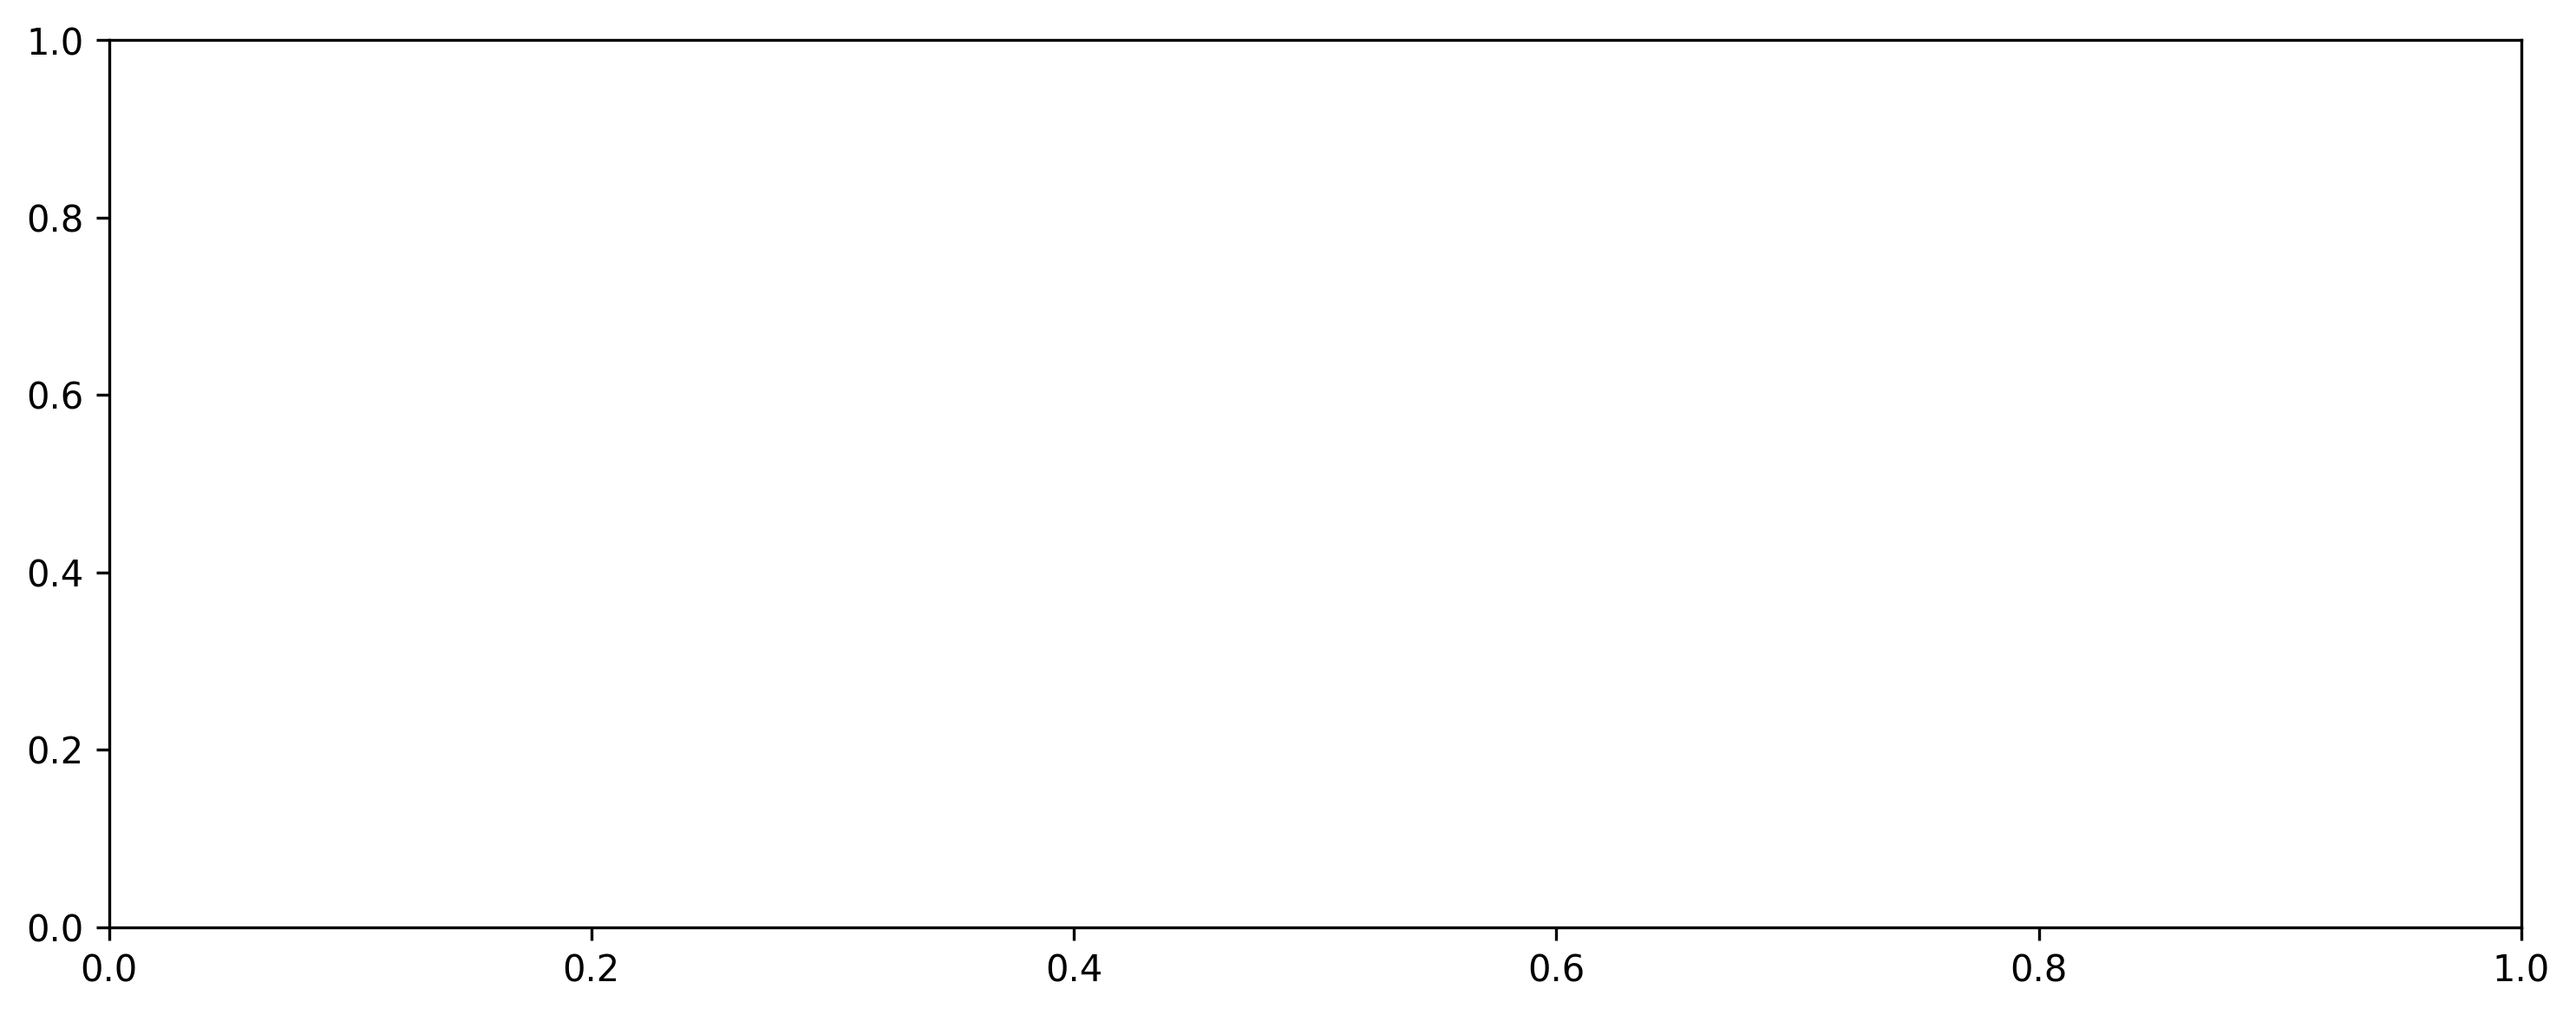

In [6]:
for ds_id,ds_smps in smp_dict.items():
    df = ds_df_dict[ds_id]
    for tgt_id,smps in ds_smps.items():
        print(f"dataset id: {ds_id}  target_id: {tgt_id}")
        for smp in smps:
            frm_id = smp[1]
            nbr_ids = smp[3:]
            # print(f"dataset id: {ds_id}  target_id: {tgt_id}, frm_id: {frm_id}, nbr_id: {nbr_ids}")

            # local_pos,orie = get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id)
            glb_pos,orie = get_glb_pos_orie(df,tgt_id,nbr_ids,frm_id)
            # print(local_pos)
            # print(orie)
            fut_pred = fut_preds_dict[ds_id][tgt_id][frm_id]
            plot_frm(glb_pos,fut_pred,frm_id)
            # print(fut_pred)
            # orie_fut_pred = get_rotated_fut(fut_pred,orie)
            # print(orie_fut_pred)
            # plot_frm(local_pos,orie_fut_pred,frm_id)
            break
        break
    break
            

In [ ]:
import pickle
with open("/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ngsim_samples_list/ngsim_samples_ds1", 'rb') as fp:  # Unpickling
    temp = pickle.load(fp)
    print(len(temp))
    print(temp)
    lc = [i for i in temp if i[3]==1]
    no_lc = [i for i in temp if i[3]==0]
    print(len(lc),len(no_lc),len(lc)/len(no_lc))
    print(len(lc),len(no_lc))

In [2]:
import pickle
with open("ld_data/processed_ibeo_samples_list/OD_LiangDao_20220318_9988_151727_fusion_00_cut", "rb") as fp:  # Unpickling
    samples_val = pickle.load(fp)
print(len(samples_val))
print(samples_val[:10])
ids = set()
for sample in samples_val:
    if 450<=sample[1]<=650:
        for id in sample[2:]:
            ids.add(id)
print(ids)
for id in ids:
    frm_range = [i[1] for i in samples_val if i[2]==id]
    sz = len(frm_range)
    print(id,sz,min(frm_range),max(frm_range))


FileNotFoundError: [Errno 2] No such file or directory: 'OD_LiangDao_20220318_9988_151727_fusion_00_cut'